In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from scipy.spatial import distance
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,homogeneity_score,contingency_matrix
from SpatialCVGAE.adj import graph
from SpatialCVGAE.train_VGAE import train_model
from SpatialCVGAE.VGAE_model import VGAE
from SpatialCVGAE.utils import *

In [2]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    cm = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

def seed_everything(random_seed=0):
    seed = random_seed
    import random
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [3]:
#run SpatialCVGAE

151508 7
AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Manual annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
Size of input (4384, 3000)


100%|██████████| 1000/1000 [00:14<00:00, 71.22it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
mclust ari is: 0.4766
mclust nmi is: 0.5688
mclust hs is: 0.5567
mclust purity is: 0.6471
mclust ari is: 0.4925
mclust nmi is: 0.5896
mclust hs is: 0.5770
mclust purity is: 0.6578
151508 7
AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Manual annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
Size of input (4384, 3000)


100%|██████████| 1000/1000 [00:12<00:00, 78.48it/s]

fitting ...


  |======================================================================| 100%
mclust ari is: 0.4839
mclust nmi is: 0.5940
mclust hs is: 0.5841
mclust purity is: 0.6387
mclust ari is: 0.5067
mclust nmi is: 0.6248
mclust hs is: 0.6147
mclust purity is: 0.6542
151508 7
AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Manual annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
Size of input (4384, 3000)


100%|██████████| 1000/1000 [00:12<00:00, 78.78it/s]


fitting ...
  |======================================================================| 100%
mclust ari is: 0.4394
mclust nmi is: 0.5628
mclust hs is: 0.5603
mclust purity is: 0.7147
mclust ari is: 0.4533
mclust nmi is: 0.5833
mclust hs is: 0.5805
mclust purity is: 0.7252


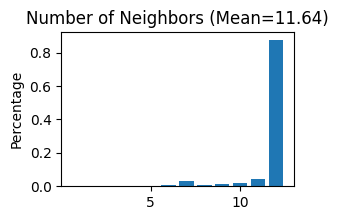

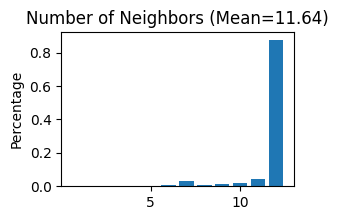

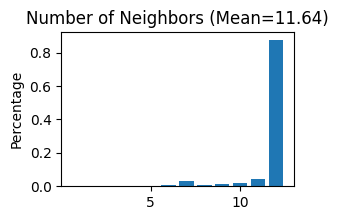

In [4]:
seed_list = [1,2,3]
 
for seed in seed_list:
    seed_everything(seed)
    
    DLPFC_dir = "../../dataset/DLPFC"
    
    section_id = '151508'
    
    clustering_n = 7
    
    print(section_id, clustering_n)
    ann_data_raw = sc.read_visium(os.path.join(DLPFC_dir, section_id),
                              count_file=section_id + '_filtered_feature_bc_matrix.h5')
    # load groud truth
    ann_df = pd.read_csv(os.path.join(DLPFC_dir, section_id, section_id + "_truth.txt"),
                         sep="\t", header=None, index_col=0)
    ann_df.columns = ["Manual annotation"]
    ann_data_raw.obs.loc[:, "Manual annotation"] = ann_df.loc[ann_data_raw.obs_names, 'Manual annotation']
    ann_data_raw.var_names_make_unique()
    print(ann_data_raw)
    
    ann_data = ann_data_raw.copy()

    sc.pp.highly_variable_genes(ann_data, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(ann_data, target_sum=1e4)
    sc.pp.log1p(ann_data)

    net = graph(ann_data)
    net.compute_spatial_net()
    net.Stats_Spatial_Net()

    ann_data = train_model(ann_data, input_dim=3000, seed=seed, mse_weight=1, bce_weight=0.1, kld_weight=0.1)

    adata = mclust_R(ann_data, used_obsm='z', num_cluster=clustering_n)
    indices = np.logical_not(ann_data.obs["Manual annotation"].isna())
    ground_truth = ann_data.obs["Manual annotation"].dropna()
    mclust_ari = adjusted_rand_score(ann_data.obs['mclust'][indices], ground_truth[indices])
    print("mclust ari is: {:.4f}".format(mclust_ari))
    mclust_nmi = normalized_mutual_info_score(ann_data.obs['mclust'][indices], ground_truth[indices])
    print("mclust nmi is: {:.4f}".format(mclust_nmi))
    mclust_hs = homogeneity_score(ann_data.obs['mclust'][indices], ground_truth[indices])
    print("mclust hs is: {:.4f}".format(mclust_hs))
    mclust_purity = purity_score(ann_data.obs['mclust'][indices], ground_truth[indices])
    print("mclust purity is: {:.4f}".format(mclust_purity))

    adj_2d = distance.cdist(ann_data.obsm['spatial'], ann_data.obsm['spatial'], 'euclidean')
    refined_pred= refine(sample_id=ann_data.obs.index.tolist(), 
                                 pred=ann_data.obs["mclust"].tolist(), dis=adj_2d, shape="hexagon")
    ann_data.obs["mclust_refine"]= refined_pred
    indices = np.logical_not(ann_data.obs["Manual annotation"].isna())
    ground_truth = ann_data.obs["Manual annotation"].dropna()
    mclust_ari = adjusted_rand_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
    print("mclust ari is: {:.4f}".format(mclust_ari))
    mclust_nmi = normalized_mutual_info_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
    print("mclust nmi is: {:.4f}".format(mclust_nmi))
    mclust_hs = homogeneity_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
    print("mclust hs is: {:.4f}".format(mclust_hs))
    mclust_purity = purity_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
    print("mclust purity is: {:.4f}".format(mclust_purity))
    
    
    file = ann_data.obs['mclust_refine']
    np.save(os.path.join('option 3',section_id,'version_'+str(seed),section_id+'_pred.npy'), file)

In [5]:
#consensus clustering

In [6]:
import glob
import itertools
from typing import List
from scipy.spatial import distance
from scipy.cluster import hierarchy


def labels_connectivity_mat(labels: np.ndarray):
    _labels = labels - np.min(labels)
    n_classes = np.unique(_labels)
    mat = np.zeros([labels.size, labels.size])
    for i in n_classes:
        indices = np.squeeze(np.where(_labels == i))  #将属于各个类的标签提取出来
        row_indices, col_indices = zip(*itertools.product(indices, indices))
        mat[row_indices, col_indices] = 1
    return mat


def consensus_matrix(labels_list: List[np.ndarray]):
    mat = 0
    for labels in labels_list:
        mat += labels_connectivity_mat(labels)
    return mat / float(len(labels_list))


def plot_consensus_map(cmat, method="average", return_linkage=True, **kwargs):
    row_linkage = hierarchy.linkage(distance.pdist(cmat), method=method)
    col_linkage = hierarchy.linkage(distance.pdist(cmat.T), method=method)
    figure = sns.clustermap(cmat, row_linkage=row_linkage, col_linkage=col_linkage, **kwargs)
    if return_linkage:
        return row_linkage, col_linkage, figure
    else:
        return figure

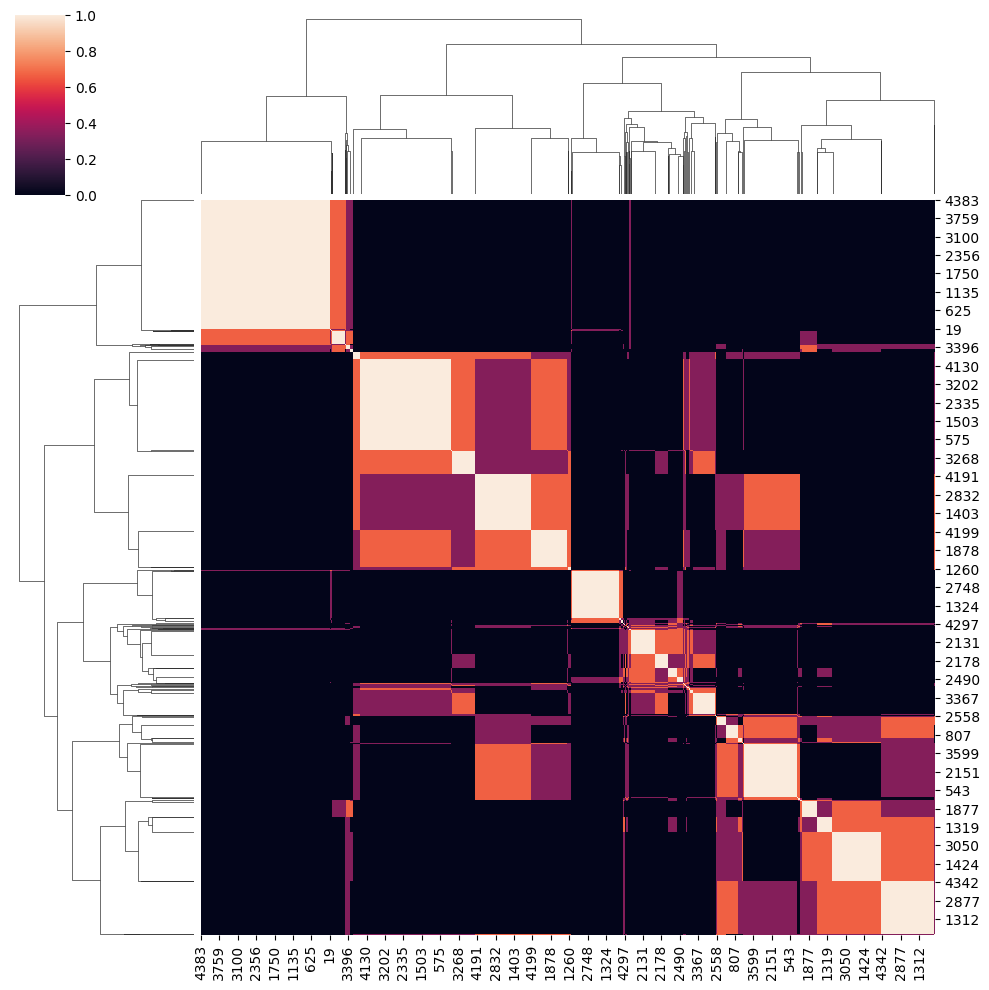

In [7]:
save_dir = os.path.join('option 3',section_id)
name = section_id+"_pred.npy"
num_cluster = clustering_n 

sys.setrecursionlimit(100000)
label_files = glob.glob(save_dir + f"/version_*/{name}")
labels_list = list(map(lambda file: np.load(file), label_files))
cons_mat = consensus_matrix(labels_list)
row_linkage, _, figure = plot_consensus_map(cons_mat, return_linkage=True)  # 获取层次聚类结果和热度图
figure.savefig(os.path.join(save_dir, "consensus_clustering.png"), dpi=300)  # 保存图片
consensus_labels = hierarchy.cut_tree(row_linkage, num_cluster).squeeze()  # 得到y*
np.save(os.path.join(save_dir, "consensus_labels"), consensus_labels)

In [8]:
pred = np.load(os.path.join('option 3',section_id,'consensus_labels.npy'))
indices = np.logical_not(ann_data.obs["Manual annotation"].isna())
ground_truth = ann_data.obs["Manual annotation"].dropna()
ari = adjusted_rand_score(pred[indices], ground_truth[indices])
print("ari is: {:.4f}".format(ari))
nmi = normalized_mutual_info_score(pred[indices], ground_truth[indices])
print("nmi is: {:.4f}".format(nmi))
hs = homogeneity_score(pred[indices], ground_truth[indices])
print("hs is: {:.4f}".format(hs))
purity = purity_score(pred[indices], ground_truth[indices])
print("purity is: {:.4f}".format(purity))

ari is: 0.4966
nmi is: 0.6211
hs is: 0.6000
purity is: 0.6720
